In [ ]:
##ref (Custom Ensemble Model) :  https://pdfs.semanticscholar.org/449e/7116d7e2cff37b4d3b1357a23953231b4709.pdf

In [27]:
import tqdm
import numpy as np
import pandas as pd
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

sns.set_style(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [19]:
#We have use this fuction to print the confusion, Precision and Recall matrix 
#reference: https://colab.research.google.com/drive/1YQoysuPgCDJ_HyOuclAYMVd04JNAjzP6

def plot_confusion_matrix(test_y, predict_y):
    #Confusion matrix
    C = confusion_matrix(test_y, predict_y)
    
    #precision matrix 
    A =(((C.T)/(C.sum(axis=1))).T)
    
    #recall matrix 
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")

    #Heatmap of Confusion matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    #Heatmap of Presicion matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    #Heatmap of Recall matrix 
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [5]:
##meta data generator from the No of k models for given dataset.

def Meta_Data_Generator(data, models):
  predictions = []
  for idx in range(len(data)):
    pred = []
    for k in range(len(models)):
      pred.append(models[k].predict(data[idx].reshape(1, -1))[0])
    predictions.append(pred)
  return np.array(predictions)

In [18]:
##This Fuction defines and trains the Custom ensemble Classification model with Custom coding.... 

def Custome_classifier(kx, data_path):

  #Reads the Dataset
  data = pd.read_csv(data_path)
  
  #Train-Test Split
  X = data.iloc[:, 1:].values
  Y = np.array(list(map(int, data.iloc[:, 0].values))).reshape(-1,1)
  X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y,test_size=0.20)
  
  #D1-D2 Split
  D1_x, D2_x, D1_y, D2_y = train_test_split(X_train, y_train, stratify=y_train,test_size=0.50)

  #Train the K classifer for D1 set
  K = kx
  models = []
  for i in range(K):
    #Samling with replacment
    sample_x, _, sample_y, _ = train_test_split(D1_x, D1_y, stratify=D1_y,test_size=0.50)  
    model = DecisionTreeClassifier(max_depth=100)
    model.fit(sample_x, sample_y)
    models.append(model)

  #Prepare thr Dataset for Meta Model by Generating the Meta-Data from k models by passing the D2 set
  meta_data = pd.DataFrame(Meta_Data_Generator(D2_x, models))
  meta_data['target'] = D2_y
  
  #Trainng the meta Model
  meta_model = RandomForestClassifier(n_estimators=100, max_depth=100)
  meta_model.fit(meta_data.iloc[:, :-1].values, meta_data.iloc[:, -1].values)

  #Getting the Predictions for Test set and then Calcukating the "Micro-F1-Score".
  meta_test = Meta_Data_Generator(X_test, models)
  y_true = y_test
  pred_y = meta_model.predict(meta_test)
  return f1_score(y_true, pred_y, average='micro'), y_true, pred_y

##Datset with (Measure Columns) Only:

In [8]:
##Hyperparameter tuning for number of base models (k)

#Selecting the Dataset path
path = '/content/drive/My Drive/Case-Study 2 /Datasets/final_data.csv'

score1 = {}
for k in tqdm.tqdm_notebook([5, 10, 50, 100, 200, 500, 1000]):
 score1[k], _, _ = Custome_classifier(k, path)

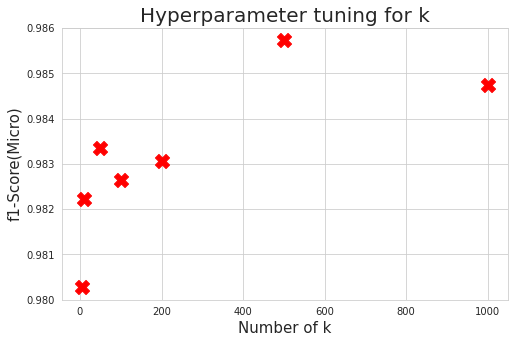

In [9]:
##Plotting the results of Hyperparameter Tuning 

fig = plt.figure(figsize=(8,5))
plt.scatter(score1.keys(), score1.values(), marker='X', c='r', s=200)
plt.title("Hyperparameter tuning for k", fontsize=20)
plt.xlabel("Number of k", fontsize=15)
plt.ylabel("f1-Score(Micro)", fontsize=15)
plt.show()

here we can see that for only measure's columns dataset,  we have achived micro f1-score ~0.9860 with k=500, so now we are going to train our model with k=50

best No of K =  500 Test-f1-score =  0.98600811529313


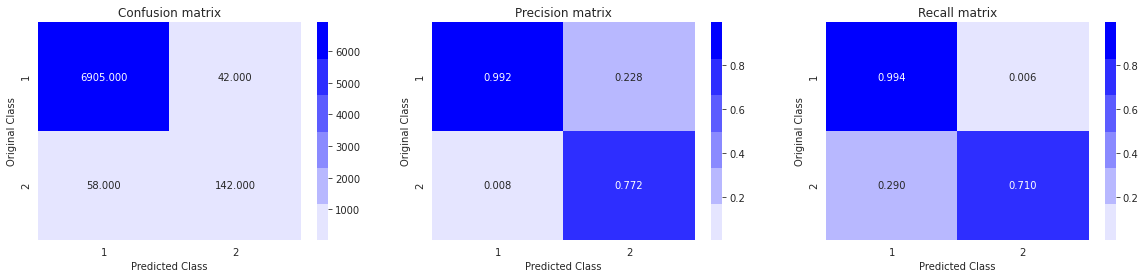

In [26]:
##Training our model with best K

#Selecting the Dataset path
path = '/content/drive/My Drive/Case-Study 2 /Datasets/final_data.csv'
score, y_true, pred_y = Custome_classifier(500, path)
print("best No of K = ",500,"Test-f1-score = ", score)
plot_confusion_matrix(y_true, pred_y)

after training the ensemble model with best k=50, results have been improved as compare to our old results thatwe have noted for single classifier (e.g logistic regression, svm, decision-tree, random,forest etc...),
  micro f1-score doesn't improved much but the precision and Recall become batter as compare to the previous results..

##Dataset with (Measure Columns + Histogram bins Columns):

In [13]:
##Hyperparameter tuning for number of base models (k)

#Selecting the Dataset path
path = '/content/drive/My Drive/Case-Study 2 /Datasets/histo_final_data.csv'

score2 = {}
for k in tqdm.tqdm_notebook([5, 10, 50, 100, 200, 500, 1000]):
 score2[k],_, _ = Custome_classifier(k, path)

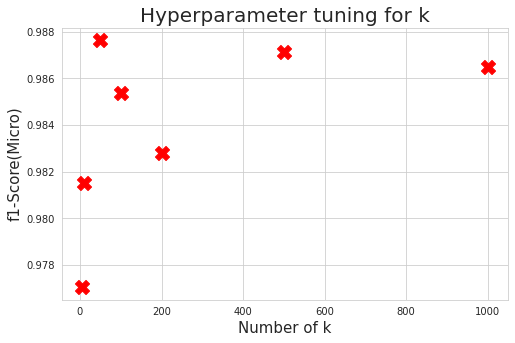

In [14]:
##Plotting the results of Hyperparameter Tuning 

fig = plt.figure(figsize=(8,5))
plt.scatter(score2.keys(), score2.values(), marker='X', c='r', s=200)
plt.title("Hyperparameter tuning for k", fontsize=20)
plt.xlabel("Number of k", fontsize=15)
plt.ylabel("f1-Score(Micro)", fontsize=15)
plt.show()

here we can see that we have achived micro f1-score ~0.9880 with k=50, so now we are going to train our model with k=50

best No of K =  50 Test-f1-score =  0.9869921310422354


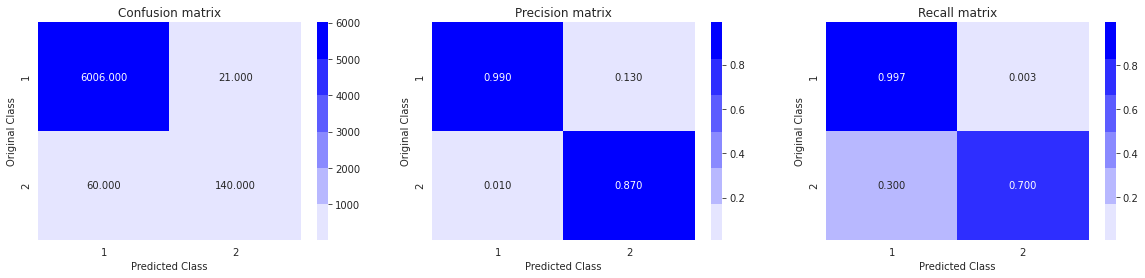

In [27]:
##Training our model with best K

#Selecting the Dataset path
path = '/content/drive/My Drive/Case-Study 2 /Datasets/histo_final_data.csv'
score, y_true, pred_y = Custome_classifier(50, path)
print("best No of K = ",50,"Test-f1-score = ", score)
plot_confusion_matrix(y_true, pred_y)

even with both type of columns's dataset (measuree + Histogram bin's columns) results are looking much better
  again micro f1-score doesn't improved much but yeah we can see improvment in  the precision and Recall matrix and also no of True Postives have increased upto ~140

##Result Comparision

In [17]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["No", "No of K", "micro F1-Score (without Histogram columns)", "micro F1-Score (with Histogram columns)"]
for idx in range(7):
  x.add_row([idx+1, list(score1.keys())[idx], list(score1.values())[idx], list(score2.values())[idx]])
print(x)

+----+---------+--------------------------------------------+-----------------------------------------+
| No | No of K | micro F1-Score (without Histogram columns) | micro F1-Score (with Histogram columns) |
+----+---------+--------------------------------------------+-----------------------------------------+
| 1  |    5    |             0.9802714425633133             |            0.9770354906054279           |
| 2  |    10   |             0.982230306422275              |            0.9815320378994701           |
| 3  |    50   |             0.9833496571988247             |            0.9876344949413843           |
| 4  |   100   |             0.9826500629634812             |            0.9853862212943633           |
| 5  |   200   |             0.9830698195046873             |            0.9828167656977678           |
| 6  |   500   |             0.9857282775989926             |            0.9871527220170226           |
| 7  |   1000  |             0.9847488456695117             |   

##Final Conclusion: 
  So, here in these experiments we have trained our custom classifier for both kind of Datasets to check with which dataset we can achieved better results, so to check this we did hyperparameter tuning for both dataset to tune the K parameter for our custom ensemble classification model
  after doing the hyperpparameter tuning for k, we have shown the results in the above table in which we can notice that Overall This Custom Ensemble classifier gave  better results with (Measure + histogram bin's columns dataset)

  in Conclusion we can choose this Custom ensemble classifier with k=500 and which has been trained by feeding the dataset which contains (measure and Histogram bin's column).

  Thank You 